In [1]:
import flopy; import sys; import pathlib; import os; import time; import numpy as np; import matplotlib.pyplot as plt
import pandas as pd
exe_name_mf = 'E:\\15_REPOS\\00_BETAMI\\w10_______others\\06_MT3D_Wisconsin-Madison\\bin\\mf2005'
exe_name_mt = 'E:\\15_REPOS\\00_BETAMI\\w10_______others\\06_MT3D_Wisconsin-Madison\\bin\\mt3d-usgs_1.1.0_64'
current_directory = os.getcwd();  print(current_directory)

E:\15_REPOS\00_BETAMI\w10_______others\06_MT3D_Wisconsin-Madison\08


In [2]:
path = pathlib.Path('E:\\15_REPOS\\00_BETAMI\\w10_______others\\06_MT3D_Wisconsin-Madison\\08')
path.mkdir(parents=True, exist_ok=True); os.chdir(path); current_directory = os.getcwd()
directory_name = 'macrodispersion_illustration'           ; workdir = os.path.join('.', directory_name)
if os.path.isdir(workdir) is False:
    os.mkdir(workdir) 
datadir = os.path.join('..', directory_name, 'mt3d_test', 'mt3dms')
folder_w_datafile = ('E:\\15_REPOS\\00_BETAMI\\w10_______others\\06_MT3D_Wisconsin-Madison\\data_for_models')
datafile_name1 = 'anisotropic_perm_field_sig100.csv'       ; data_file_with_path1 = os.path.join(folder_w_datafile, datafile_name1)             
datafile_name2 = 'anisotropic_perm_field_sig100000.csv'    ; data_file_with_path2 = os.path.join(folder_w_datafile, datafile_name2) 

In [3]:
kdata_m2   = np.loadtxt(data_file_with_path1, delimiter=',')                        # anisotropic_perm_field_sig100.csv
nrow       = int(kdata_m2[-2])       ; ncol = int(kdata_m2[-1])                   ; print('Nrows = ' + str(nrow), 'Ncolumns = ' + str(ncol))
kdata_m2   = kdata_m2[0:-2]          ; rawk_m2 = kdata_m2.reshape(1, nrow, ncol)  ; # print('Vector = ', kdata_m2.shape)   
hk_weak    = rawk_m2*(1000*9.81*100/8.9E-4)                                         # Permeabiltiy (in m^2) to K (cm/sec)

kdata_m2   = np.loadtxt(data_file_with_path2, delimiter=',')                      ; print('kdata_m2.shape', kdata_m2.shape)
nrow       = int(kdata_m2[-2])       ; ncol = int(kdata_m2[-1])                   ; # print('Nrows = ' + str(nrow), 'Ncolumns = ' + str(ncol))
kdata_m2   = kdata_m2[0:-2]          ; rawk_m2 = kdata_m2.reshape(1, nrow, ncol)  ; # print('Vector = ', kdata_m2.shape)   
hk_strong  = rawk_m2*(1000*9.81*100/8.9E-4)                                         # sa = rawk_m2[0,:,:]

geo_mean_weak   = np.exp(np.sum(np.log(hk_weak))   / hk_weak.size)                ; print('K      =', geo_mean_weak,   'cm/sec')
geo_mean_strong = np.exp(np.sum(np.log(hk_strong)) / hk_strong.size)              ; print('Kstrong=', geo_mean_strong, 'cm/sec')
hk_hom          = geo_mean_weak*np.ones([1, 20, 40]) ; perlen_mt = [60*3,60*58]   ; v = 0.01 ; al = 0.2 ; trpt = 0.1 ; itype= -1

Nrows = 20 Ncolumns = 40
kdata_m2.shape (802,)
K      = 0.0005412218263527298 cm/sec
Kstrong= 0.0007188879381530694 cm/sec


In [4]:
bawk_m2 = kdata_m2.reshape(nrow, ncol) ; save = pd.DataFrame(bawk_m2) ; save.to_csv ("01.csv")  ; # print('bdata_m2.shape',bawk_m2.shape)

In [5]:
grid_size = [0.25, 0.25];         Lx = (ncol - 1)  * grid_size[0]             ; Ly = (nrow - 1)  * grid_size[1]   
x, y = np.mgrid[         slice(0, Lx + grid_size[0], grid_size[0]),    slice(0, Ly + grid_size[1], grid_size[1])]

def plot_2d(map_data, X, Y, cmap, colorbar_label, title_text):
    plt.figure(figsize=(5, 2), dpi=100)                        ; plt.pcolor(X,Y,map_data,cmap=cmap,shading='auto',edgecolor='k',linewidth=0.1)
    plt.gca().set_aspect('equal') ; cbar = plt.colorbar()      ; cbar.set_label(colorbar_label);  plt.title(title_text)
# plot_2d(hk_weak[0,:,:]   *60, x, y, 'cividis', 'Hydraulic conductivity [cm/min]', 'Weak heterogeneity')
# plot_2d(hk_strong[0,:,:] *60, x, y, 'cividis', 'K  [cm/min]', 'Strong heterogeneity')

In [6]:
bawk_m2 = kdata_m2.reshape(nrow, ncol) ; save = pd.DataFrame(bawk_m2) ; save.to_csv ("02.csv")  ; 

In [7]:
def model_2D(dirname, perlen_mt, hk, v, al, trpt, itype):
    model_ws = os.path.join(workdir, dirname)                        ; print(model_ws)   
    itmuni   = 1                     ; mt_tunit = 'S'                ; lenuni = 3                    ; mt_lunit = 'CM'   ; al = 0.01; trpv = 0.001/al
    perlen_mf = [np.sum(perlen_mt)]  ; nper_mf  = len(perlen_mf)     ; nper   = len(perlen_mt)       ; nprs     = 100
    timprs    = np.linspace(0, np.sum(perlen_mf), nprs, endpoint = False)                            ; hk_size  = hk.shape
    nlay = hk_size[0]                ; nrow = hk_size[1]             ;  ncol = hk_size[2]            ; # botm=-np.linspace(delv,delv*nlay,nlay)
   
    hk_size = hk.shape  ; nlay = hk_size[0]; nrow = hk_size[1]; ncol = hk_size[2]  ; delv = 0.25; delr = 0.25 ; delc = 1 ; 
    laytyp = 0          ; geo_mean_k = np.exp(np.sum(np.log(hk))/hk.size)          ; prsity = 0.3    ; q = v * prsity; Lx = (ncol - 1) * delr
    print("Model length is: " + str(Lx + delr) + " (check units of 'lenuni')")

    ibound = np.ones((nlay, nrow, ncol), dtype=int)                             ; ibound[0,:,0]= -1  ; ibound[0,:,-1] = -1 #(index)inlet|outlet
    strt   = np.zeros((nlay, nrow, ncol), dtype=float) ; h1 = q * Lx/geo_mean_k ; strt  [0,:,0]= h1  ; print("Inlet_H:"+str(h1) + "('lenuni units')")
    icbund = np.ones((nlay, nrow, ncol), dtype=int)
    sconc  = np.zeros((nlay, nrow, ncol), dtype=float)                          ; C_in = [1.0, 0.0]    
    cwell_info = np.zeros((nrow, 5), dtype=float)                               ; itype = itype
    for row in range(0, nrow):
        cwell_info[row] = [0, row, 0, C_in[0], itype]                           #  inlet face grid cell as a well
    cwell_info2 = cwell_info.copy()   
    cwell_info2[:,3] = C_in[1]          ; modelname_mf = dirname + '_mf'        ; spd_mt = {0:cwell_info, 1:cwell_info2}
    
    mf = flopy.modflow.Modflow(modelname=modelname_mf, model_ws=model_ws, exe_name=exe_name_mf)
    dis = flopy.modflow.ModflowDis(mf, nlay=nlay, nrow=nrow, ncol=ncol, nper=nper_mf, delr=delr, delc=delc, top=0., botm=[0 - delv],
                                   perlen=perlen_mf, itmuni=itmuni, lenuni=lenuni)
    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
    lpf = flopy.modflow.ModflowLpf(mf, hk=hk, laytyp=laytyp)
    pcg = flopy.modflow.ModflowPcg(mf)
    lmt = flopy.modflow.ModflowLmt(mf)
    oc = flopy.modflow.ModflowOc(mf)    ; mf.write_input()   ; mf.run_model(silent=True)       ; modelname_mt = dirname + '_mt'
    mt = flopy.mt3d.Mt3dms(modelname=modelname_mt, model_ws=model_ws, exe_name=exe_name_mt, modflowmodel=mf)  
    btn = flopy.mt3d.Mt3dBtn(mt, icbund=icbund, prsity=prsity, sconc=sconc, tunit=mt_tunit, lunit=mt_lunit, nper=nper, 
                             perlen=perlen_mt, nprs=nprs, timprs=timprs)                                                   ; mixelm = -1
    adv = flopy.mt3d.Mt3dAdv(mt, mixelm=mixelm)
    dsp = flopy.mt3d.Mt3dDsp(mt, al=al, trpt=trpt)
    ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=spd_mt)
    gcg = flopy.mt3d.Mt3dGcg(mt)       ; mt.write_input()    ; 
    
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    if os.path.isfile(fname):
        os.remove(fname)
    mt.run_model(silent=True)
    
    fname = os.path.join(model_ws, modelname_mf+'.hds')     ; hdobj  = flopy.utils.HeadFile(fname)   ; heads = hdobj.get_data()
    fname = os.path.join(model_ws, 'MT3D001.UCN')           ; ucnobj = flopy.utils.UcnFile(fname)    ; times = np.array(ucnobj.get_times())
    conc = ucnobj.get_alldata()
    return mf, mt, times, conc, heads

In [8]:
dirname = 'homogeneous_2D'                  ; mf, mt, times, conc, heads          = model_2D(dirname, perlen_mt, hk_hom,    v, al, trpt, itype) 
dirname = 'anisotropic_weak'                ; mf, mt, times_w, conc_weak, heads   = model_2D(dirname, perlen_mt, hk_weak,   v, al, trpt, itype)
dirname = 'anisotropic_strong'              ; mf, mt, times_s, conc_strong, heads = model_2D(dirname, perlen_mt, hk_strong, v, al, trpt, itype)

.\macrodispersion_illustration\homogeneous_2D
Model length is: 10.0 (check units of 'lenuni')
Inlet_H:54.04438360720681('lenuni units')
.\macrodispersion_illustration\anisotropic_weak
Model length is: 10.0 (check units of 'lenuni')
Inlet_H:54.04438360720681('lenuni units')
.\macrodispersion_illustration\anisotropic_strong
Model length is: 10.0 (check units of 'lenuni')
Inlet_H:40.687843609043746('lenuni units')


In [9]:
from scipy.special import erfc as erfc    ; from scipy.special import erf as erf
def analytical_model_1D_finite_t1(x, t, v, al, L):
    D = v*al
    indices_below_zero = t <= 0
    if indices_below_zero.any() == True:
        t[indices_below_zero] = 1
    C = (1/2)*erfc((x - v*t)/(2*np.sqrt(D*t))) + (1/2)*np.exp(v*x/D)*erfc((x + v*t)/(2*np.sqrt(D*t))) + \
        (1/2)*(2 + (v*(2*L - x)/D) + v**2*t/D)* np.exp(v*L/D)*erfc(((2*L - x)+ v*t)/(2*np.sqrt(D*t))) - \
        (v**2 *t/(3.1415*D))**(1/2) * np.exp(v*L/D - ((2*L - x + v*t)**2)/(4*D*t))
    if indices_below_zero.any() == True:
        C[indices_below_zero] = 0
    return C

What are the boundary conditions (both inlet and outlet) of the function we just defined? It is the correct BC to compare with out numerical model?

In [10]:
ym, xm, zm = mf.dis.get_node_coordinates()     ; print(xm)

[0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875 2.125 2.375 2.625 2.875
 3.125 3.375 3.625 3.875 4.125 4.375 4.625 4.875 5.125 5.375 5.625 5.875
 6.125 6.375 6.625 6.875 7.125 7.375 7.625 7.875 8.125 8.375 8.625 8.875
 9.125 9.375 9.625 9.875]


In [11]:
Conc_time_type1_t    = analytical_model_1D_finite_t1(xm[-1], times, v, al, xm[-1])        ; t_t0 = times - perlen_mt[0]
Conc_time_type1_t_t0 = analytical_model_1D_finite_t1(xm[-1], t_t0,  v, al, xm[-1])
Conc_pulse_solution  = Conc_time_type1_t - Conc_time_type1_t_t0
C_btc_h = np.mean([conc       [:, 0, :, -1]], axis=2)   
C_btc_w = np.mean([conc_weak  [:, 0, :, -1]], axis=2)
C_btc_s = np.mean([conc_strong[:, 0, :, -1]], axis=2)

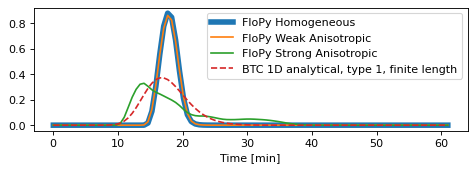

In [12]:
plt.figure(figsize=(7, 2), dpi=80)
plt.plot(times  /60, np.transpose(C_btc_h), linewidth = 5, label='FloPy Homogeneous')
plt.plot(times_w/60, np.transpose(C_btc_w),                label='FloPy Weak Anisotropic')
plt.plot(times_s/60, np.transpose(C_btc_s),                label='FloPy Strong Anisotropic')
plt.plot(times  /60, Conc_pulse_solution, '--',            label='BTC 1D analytical, type 1, finite length')
plt.xlabel('Time [min]')   ; plt.legend()    ; plt.show()

Model time: 5.48999989827474 min


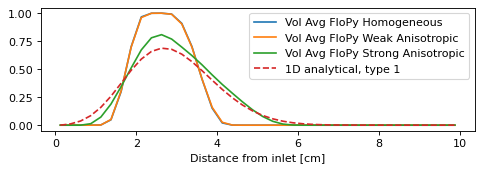

In [13]:
timestep = 10     ; print('Model time: ' + str(times[timestep]/60) + ' min') ; plt.figure(figsize=(7, 2), dpi=80)
C_profile_h = np.mean([conc[timestep,        0, :, :]], axis=1)
C_profile_w = np.mean([conc_weak[timestep,   0, :, :]], axis=1)
C_profile_s = np.mean([conc_strong[timestep, 0, :, :]], axis=1)

Conc_time_type1_x    = analytical_model_1D_finite_t1(xm-xm[0], times[timestep], v, al, xm[-1])     ; time_t0 = times[timestep] - perlen_mt[0]
Conc_time_type1_x_t0 = analytical_model_1D_finite_t1(xm-xm[0], time_t0,         v, al, xm[-1])

Conc_pulse_solution_in_space = Conc_time_type1_x - Conc_time_type1_x_t0

plt.plot(xm, np.transpose(C_profile_h), label='Vol Avg FloPy Homogeneous') ; plt.plot(xm, np.transpose(C_profile_w), label='Vol Avg FloPy Weak Anisotropic')
plt.plot(xm, np.transpose(C_profile_s), label='Vol Avg FloPy Strong Anisotropic') ; plt.plot(xm, Conc_pulse_solution_in_space, '--', label='1D analytical, type 1')
plt.xlabel('Distance from inlet [cm]') ; plt.legend() ; plt.show()

In [14]:
def spatial_moment_calc(conc, timestep): ### BUUGGG X
    C_x = np.sum([conc[timestep, 0, :, :]], axis=1)   ; Mx0 = np.trapz(C_x, xm)   ; print('Zero moment =    ' + str(Mx0  )        )
    Mx1 = np.trapz(xm*C_x, xm)                        ; x_bar = Mx1/Mx0           ; print('Center of mass = ' + str(x_bar) + ' cm')
    # Second spatial moment      # Mx2 = # FILL THIS IN   
    var = 0 # FILL THIS IN
    return x_bar, var

In [15]:
x_bar1, var1 = spatial_moment_calc(conc_strong, timestep    )
x_bar2, var2 = spatial_moment_calc(conc_strong, timestep + 1)
# 0 # FILL THIS IN          # Now use equation from class to calculate the value of the macrodispersion
#print(D_macro)  ; # al_macro = D_macro/v  ; # print(al_macro)

Zero moment =    [37.88282]
Center of mass = [2.9643478] cm
Zero moment =    [37.882812]
Center of mass = [3.3819053] cm


Your value of macrodispersivity should be larger than the dispersivity (```al```) defined above, but of the same order of magnitude. 

In [16]:
al_macro =0.4
Conc_time_type1_x    = analytical_model_1D_finite_t1(xm-xm[0], times[timestep], v, al_macro, xm[-1]) ;    time_t0 = times[timestep] - perlen_mt[0]
Conc_time_type1_x_t0 = analytical_model_1D_finite_t1(xm-xm[0], time_t0,         v, al_macro, xm[-1])
Conc_pulse_solution_in_space_macro = Conc_time_type1_x - Conc_time_type1_x_t0

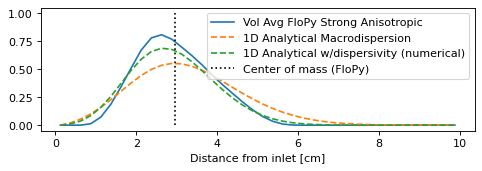

In [17]:
plt.figure(figsize=(7, 2), dpi=80)
plt.plot(xm, np.transpose (C_profile_s), label              ='Vol Avg FloPy Strong Anisotropic')
plt.plot(xm, Conc_pulse_solution_in_space_macro, '--', label='1D Analytical Macrodispersion')
plt.plot(xm, Conc_pulse_solution_in_space, '--', label      ='1D Analytical w/dispersivity (numerical)')
plt.plot([x_bar1, x_bar1], [0, 1], 'k:', label              ='Center of mass (FloPy)')
plt.xlabel('Distance from inlet [cm]')                      ; plt.legend()

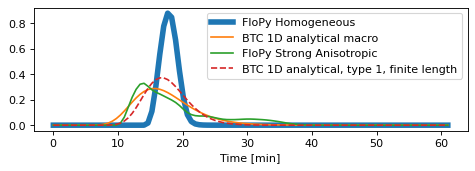

In [18]:
Conc_time_type1_t    = analytical_model_1D_finite_t1(xm[-1], times, v, al_macro, xm[-1])     ; t_t0 = times - perlen_mt[0]
Conc_time_type1_t_t0 = analytical_model_1D_finite_t1(xm[-1], t_t0,  v, al_macro, xm[-1])
Conc_pulse_solution_macro = Conc_time_type1_t - Conc_time_type1_t_t0                         ; plt.figure(figsize=(7, 2), dpi=80)
plt.plot(times/60, np.transpose(C_btc_h), linewidth = 5, label ='FloPy Homogeneous')
plt.plot(times/60, Conc_pulse_solution_macro, label            ='BTC 1D analytical macro')
plt.plot(times_s/60, np.transpose(C_btc_s), label              ='FloPy Strong Anisotropic')
plt.plot(times/60, Conc_pulse_solution, '--', label            ='BTC 1D analytical, type 1, finite length')
plt.xlabel('Time [min]') ; plt.legend()

Why does the 1D analytical (larger dispersivity) better match the heterogeneous numerical ?